<h1>Sheep and Owls Detection with YOLOv8

This Jupyter Notebook takes you through each step of training a detection model. It includes clear explanations and points out the tricky parts.

# Dataset


---

 In *download_dataset.py*

Following the recommendations in the [Open Images Dataset v7 documentation](https://storage.googleapis.com/openimages/web/download_v7.html), I utilized FiftyOne to download and visualize a subset of the Open Images dataset.



In [ ]:
!pip install fiftyone

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# directory to save generated dataset
export_dir = "/content/drive/MyDrive/Colab Notebooks/Owl-Sheep"


label_field = "ground_truth"
splits = ["train", "validation", "test"]
classes = ["Sheep", "Owl"]

In [ ]:
dataset = foz.load_zoo_dataset(
              "open-images-v7",
              splits = splits,
              label_types="detections",
              classes = classes,
              seed=51,
              max_samples = 1000, # max samples for every split, not class
              shuffle=True,
              dataset_name="open-images-owl-sheep"
          )


In [ ]:
# optional - for visualization of dataset
app_config = fo.AppConfig()
app_config.show_attributes = True
session = fo.launch_app(dataset, config=app_config)

The YOLO framework adopts a unique approach to image annotation, differing from the method used in the Open Images dataset. Consequently, the dataset is converted into the YOLOv5Dataset format, which is also compatible with YOLOv8.

In [ ]:
for split in splits:
    split_view = dataset.match_tags(split)
    split_view.export(
        export_dir=export_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=label_field,
        split=split,
        classes=classes,
    )

The created dataset consists of:


*   Train set: 1000 samples (456 sheep and 544 owls)
*   Validation set: 92 samples (62 sheep 30 owls)
*   Test set: 267 samples (179 sheep and 88 owls)

For the training set, I utilized a smaller subset of the available data. For both the validation and test sets, I used all the available data.





# Model and training


---

In *train.py*

We trained the model using transfered weights on Google Colab, using a T4 GPU and 12.7 GB of RAM.

In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

# build a new model from scratch
model = YOLO("yolov8n.yaml")
# load a pretrained model (recommended for training)
model = YOLO("yolov8n.pt")
 # build from YAML and transfer weights
model = YOLO('yolov8n.yaml').load('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 131MB/s]


Transferred 355/355 items from pretrained weights


## Augmentations

The following augmentations are automatically applied by default:


*   HSV Adjustments: Adjust hue (0.015), saturation (0.7), and brightness (0.4)
*   Translation: Slight image shifts (0.1)
*   Scaling: Up to 0.5 scale
*   Flip Left-Right: 50% chance of horizontal flips
*   Mosaic: Combines images (1.0) for training
*   Erasing: Erases random regions (40% chance)

Based on various recommendations, the mosaic augmentation is halted for the final 10 epochs, a practice also adopted here by default. Examples of these augmentations can be found in *runs\detect\train\train_batch0.*

## Hyperparametars

I chose the AdamW optimizer for its enhanced regularization and stability, along with a 0.001 learning rate for optimal balance between fast convergence and minimizing overshooting in training.

Some of hyperparametars that are defult:


*   Momentum: Set at 0.937
*   Weight Decay: Applied for regularization at 0.0005
*   Warmup Momentum: Begins at 0.8
*   Warmup Bias Learning Rate: Set at 0.1 for bias parameters during the warmup phase
*   Gradient Accumulation: Utilizes a nominal batch size (nbs) of 64 for accumulating gradients before each optimizer step



## How to find best augmentations and hyperparametars?


I explored the *model.tune()* method ([here](https://colab.research.google.com/drive/1SIYczR3rUVBVDnH4L1xJFZJFsrhBkELS?usp=sharing)) in Ultralytics YOLO, which employs genetic algorithms to fine-tune augmentations and hyperparameters. However, due to its computationally intensive nature, I didn't utilize its potential in my project.

In [ ]:
results = model.train(data="/content/drive/MyDrive/Colab Notebooks/Owl-Sheep/dataset.yaml", epochs=100, imgsz =  640, optimizer ="AdamW", lr0= 1e-3)  # train the model

Ultralytics YOLOv8.1.11 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/MyDrive/Colab Notebooks/Owl-Sheep/dataset.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, s

100%|██████████| 755k/755k [00:00<00:00, 44.0MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/Colab Notebooks/Owl-Sheep/labels/train.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Colab Notebooks/Owl-Sheep/labels/validation.cache... 92 images, 0 backgrounds, 0 corrupt: 100%|██████████| 92/92 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.43G      1.195       2.17      1.356         33        640: 100%|██████████| 63/63 [01:14<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

                   all         92        152      0.592      0.551      0.529      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.29G      1.223      1.671      1.397         28        640: 100%|██████████| 63/63 [00:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         92        152      0.332       0.44      0.321      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.28G      1.215      1.525      1.406         21        640: 100%|██████████| 63/63 [00:34<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all         92        152      0.359      0.397      0.353      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.46G      1.232      1.538      1.428         38        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         92        152      0.638      0.374      0.445      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.29G      1.241      1.513      1.428         47        640: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all         92        152      0.404      0.491      0.488      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.49G      1.218      1.419      1.395         18        640: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                   all         92        152      0.429      0.634      0.486      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.29G      1.193      1.392      1.394         45        640: 100%|██████████| 63/63 [00:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         92        152      0.547       0.65      0.585       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.38G       1.19       1.38      1.377         22        640: 100%|██████████| 63/63 [00:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all         92        152       0.57      0.654      0.627      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.29G      1.141      1.314      1.371         48        640: 100%|██████████| 63/63 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         92        152      0.652      0.642      0.639      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.31G      1.145      1.305      1.358         32        640: 100%|██████████| 63/63 [00:34<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         92        152      0.558      0.598      0.527      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.29G      1.111      1.247       1.34         15        640: 100%|██████████| 63/63 [00:35<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

                   all         92        152      0.634      0.609      0.604      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.47G      1.103      1.195      1.331         40        640: 100%|██████████| 63/63 [00:37<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         92        152      0.674      0.567      0.645      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.46G      1.067      1.166      1.303         28        640: 100%|██████████| 63/63 [00:36<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

                   all         92        152      0.665      0.706      0.685      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.28G      1.095      1.178      1.316         93        640: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         92        152      0.669       0.64      0.653      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.26G      1.094      1.167      1.311         36        640: 100%|██████████| 63/63 [00:34<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         92        152      0.581      0.675      0.622      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.21G       1.06      1.135      1.281         91        640: 100%|██████████| 63/63 [00:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         92        152      0.588      0.666      0.627      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.44G      1.059      1.086      1.283         41        640: 100%|██████████| 63/63 [00:36<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         92        152      0.631      0.576      0.594      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.28G      1.025      1.073      1.274         55        640: 100%|██████████| 63/63 [00:36<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

                   all         92        152      0.626       0.63      0.585      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.29G      1.029      1.046      1.271         23        640: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         92        152      0.647      0.654      0.671      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.29G      1.056      1.083      1.298         44        640: 100%|██████████| 63/63 [00:35<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         92        152      0.668      0.618      0.637      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.34G      1.029      1.065      1.274         24        640: 100%|██████████| 63/63 [00:36<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         92        152      0.702      0.614      0.643       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.44G      1.016      1.028      1.258         26        640: 100%|██████████| 63/63 [00:35<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         92        152      0.621      0.764      0.684      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.28G     0.9981      1.031      1.254         26        640: 100%|██████████| 63/63 [00:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         92        152      0.657      0.652      0.701      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.28G     0.9996     0.9865      1.241         26        640: 100%|██████████| 63/63 [00:35<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]

                   all         92        152      0.672      0.707        0.7      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.41G      1.007       1.02      1.263         24        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         92        152      0.626      0.739      0.654      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.28G     0.9744     0.9708      1.235         34        640: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all         92        152      0.672       0.65       0.64       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.43G     0.9841     0.9626      1.252         17        640: 100%|██████████| 63/63 [00:36<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         92        152      0.684      0.663      0.698      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.28G     0.9621     0.9411      1.227         46        640: 100%|██████████| 63/63 [00:36<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]

                   all         92        152      0.723      0.672        0.7      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.46G     0.9802      0.937      1.234         29        640: 100%|██████████| 63/63 [00:36<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all         92        152      0.662      0.601      0.636      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.28G     0.9549     0.9266      1.226         37        640: 100%|██████████| 63/63 [00:35<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         92        152      0.692      0.684      0.677      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.43G     0.9504     0.9023      1.203         38        640: 100%|██████████| 63/63 [00:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all         92        152      0.604       0.73      0.684      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.44G     0.9273      0.886      1.206         34        640: 100%|██████████| 63/63 [00:35<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all         92        152      0.746       0.72      0.731      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.29G     0.9335     0.8675      1.195         25        640: 100%|██████████| 63/63 [00:35<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                   all         92        152      0.728      0.717       0.73      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.26G     0.9364     0.8793      1.204         30        640: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all         92        152      0.747      0.628      0.696      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.43G      0.918      0.869      1.201         43        640: 100%|██████████| 63/63 [00:36<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

                   all         92        152      0.635       0.75      0.707      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.29G     0.9172     0.8381      1.174         39        640: 100%|██████████| 63/63 [00:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         92        152      0.738      0.667       0.73      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.44G     0.9037     0.8533      1.183         39        640: 100%|██████████| 63/63 [00:34<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         92        152      0.673       0.69      0.691      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.31G     0.8765     0.8261      1.181         26        640: 100%|██████████| 63/63 [00:35<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all         92        152      0.757      0.666      0.741      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.28G     0.8784     0.8019      1.162         30        640: 100%|██████████| 63/63 [00:36<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all         92        152      0.636       0.69      0.671      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.46G     0.8818     0.8213      1.168         30        640: 100%|██████████| 63/63 [00:36<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all         92        152      0.681      0.771      0.693      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.58G     0.8827     0.7914      1.164         32        640: 100%|██████████| 63/63 [00:36<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         92        152      0.747        0.7      0.714      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.36G     0.8778     0.7912      1.161         24        640: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         92        152      0.709      0.704      0.705      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.29G       0.87     0.7845      1.169         24        640: 100%|██████████| 63/63 [00:34<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         92        152        0.8      0.701      0.728      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.32G     0.8546     0.7768       1.16         32        640: 100%|██████████| 63/63 [00:35<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         92        152      0.587      0.676       0.68      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.28G     0.8744      0.787      1.169         34        640: 100%|██████████| 63/63 [00:36<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         92        152      0.701      0.688      0.697       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.28G     0.8732     0.7791      1.161         38        640: 100%|██████████| 63/63 [00:35<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all         92        152      0.741        0.7      0.726      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.28G     0.8359     0.7465      1.151         23        640: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         92        152      0.744      0.643      0.682      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.48G     0.8516     0.7535      1.162         27        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         92        152      0.721      0.717       0.72      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.44G     0.8259     0.7238      1.136         38        640: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         92        152      0.759       0.72      0.727      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.42G     0.8423     0.7129      1.136         37        640: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all         92        152      0.795       0.65       0.72      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.44G     0.8373     0.7294      1.146         31        640: 100%|██████████| 63/63 [00:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         92        152      0.724      0.666      0.707      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.32G     0.8202     0.7135      1.126         23        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         92        152      0.677      0.717      0.711      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.29G     0.7968     0.6907      1.133         42        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         92        152       0.73      0.692        0.7      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.28G     0.8446     0.7256      1.146         41        640: 100%|██████████| 63/63 [00:35<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all         92        152      0.774      0.716      0.751      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       2.6G     0.8307     0.7033      1.124         80        640: 100%|██████████| 63/63 [00:34<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         92        152      0.678      0.749      0.731       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.29G     0.8074     0.6866      1.138         32        640: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         92        152      0.695      0.729      0.721      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.29G     0.8247     0.7117      1.144         42        640: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all         92        152      0.658      0.774      0.729      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.28G     0.7944     0.6737      1.116         28        640: 100%|██████████| 63/63 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         92        152      0.779        0.7      0.718      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.42G     0.7871     0.6897      1.123         28        640: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                   all         92        152      0.731      0.745      0.743      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.29G     0.7821     0.6622      1.103         21        640: 100%|██████████| 63/63 [00:35<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         92        152      0.711      0.729      0.716      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.55G     0.7835     0.6526      1.106         29        640: 100%|██████████| 63/63 [00:36<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         92        152      0.755      0.695       0.73      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.57G     0.7822      0.661      1.111         47        640: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all         92        152      0.628      0.713      0.656      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.33G     0.7857      0.654       1.09         38        640: 100%|██████████| 63/63 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         92        152      0.828      0.695      0.774      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.29G     0.7582     0.6436      1.095         30        640: 100%|██████████| 63/63 [00:33<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all         92        152      0.766      0.725      0.743      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.43G     0.7546      0.619      1.088         43        640: 100%|██████████| 63/63 [00:34<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         92        152      0.752      0.717      0.717      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.28G     0.7586     0.6392      1.108         21        640: 100%|██████████| 63/63 [00:34<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         92        152      0.701      0.765      0.693      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.43G     0.7702     0.6445      1.098         37        640: 100%|██████████| 63/63 [00:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all         92        152      0.725      0.725      0.692      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.43G     0.7623     0.6155      1.087         46        640: 100%|██████████| 63/63 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                   all         92        152      0.714      0.774      0.749      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.29G     0.7316     0.6057      1.073         33        640: 100%|██████████| 63/63 [00:34<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all         92        152      0.776      0.736      0.716      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.47G     0.7487     0.6108      1.079         23        640: 100%|██████████| 63/63 [00:34<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         92        152       0.77      0.688      0.727      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.31G     0.7339     0.6094      1.077         25        640: 100%|██████████| 63/63 [00:35<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                   all         92        152      0.721      0.762      0.749        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.43G     0.7539     0.6055      1.087         22        640: 100%|██████████| 63/63 [00:34<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

                   all         92        152      0.762      0.774      0.776      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.28G     0.7191     0.5901      1.075         19        640: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         92        152      0.693      0.754      0.733      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.28G     0.7366     0.5783      1.077         25        640: 100%|██████████| 63/63 [00:35<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         92        152        0.7       0.78      0.739      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.29G     0.7178     0.5735      1.075         29        640: 100%|██████████| 63/63 [00:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         92        152      0.712      0.756      0.742      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.29G     0.7159     0.5736      1.063         37        640: 100%|██████████| 63/63 [00:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                   all         92        152      0.721      0.769      0.741      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.43G     0.7157     0.5701      1.062         32        640: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                   all         92        152      0.802      0.721      0.752      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.45G     0.7193     0.5749      1.064         20        640: 100%|██████████| 63/63 [00:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all         92        152      0.736      0.749       0.74      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.44G     0.7149     0.5663      1.071         22        640: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         92        152      0.779      0.655      0.712      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.29G       0.69     0.5629      1.059         22        640: 100%|██████████| 63/63 [00:35<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all         92        152      0.775      0.697      0.729      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.28G     0.7253     0.5739      1.073         39        640: 100%|██████████| 63/63 [00:36<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         92        152      0.749      0.722      0.734      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.31G     0.7185     0.5645      1.067         28        640: 100%|██████████| 63/63 [00:36<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         92        152      0.709      0.783       0.75      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.43G     0.6815     0.5352      1.036         44        640: 100%|██████████| 63/63 [00:36<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]

                   all         92        152      0.726      0.795      0.748      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.29G     0.6829     0.5313      1.041         25        640: 100%|██████████| 63/63 [00:36<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         92        152       0.75      0.737      0.738      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.43G     0.6781     0.5339      1.044         25        640: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         92        152      0.769      0.717       0.73      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.28G     0.6916     0.5463      1.046         41        640: 100%|██████████| 63/63 [00:34<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

                   all         92        152      0.793      0.717      0.748      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.29G     0.6967     0.5405      1.058         21        640: 100%|██████████| 63/63 [00:34<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all         92        152      0.716       0.75      0.713      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.29G     0.6871     0.5306      1.049         39        640: 100%|██████████| 63/63 [00:35<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all         92        152      0.818      0.696      0.733      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.28G      0.682     0.5269      1.041         22        640: 100%|██████████| 63/63 [00:36<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all         92        152      0.733       0.77      0.745      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.28G     0.6773     0.5242      1.041         26        640: 100%|██████████| 63/63 [00:35<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all         92        152      0.763      0.733      0.735      0.595


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.26G     0.6223     0.4638     0.9864         26        640: 100%|██████████| 63/63 [00:36<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all         92        152      0.766      0.712      0.745      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.27G     0.6035     0.4174     0.9705         19        640: 100%|██████████| 63/63 [00:32<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         92        152      0.748      0.717      0.718       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.31G     0.5815     0.3986      0.967         15        640: 100%|██████████| 63/63 [00:31<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         92        152      0.713      0.741      0.727      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.26G     0.5762     0.3886      0.953         33        640: 100%|██████████| 63/63 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         92        152      0.738      0.762      0.731      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.42G     0.5766     0.3947     0.9535          9        640: 100%|██████████| 63/63 [00:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all         92        152      0.795      0.737      0.744      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.27G      0.575     0.3807     0.9556         11        640: 100%|██████████| 63/63 [00:32<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         92        152      0.796      0.747      0.754      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.45G     0.5606     0.3648     0.9485         15        640: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all         92        152      0.736      0.793      0.746      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.28G     0.5646     0.3682     0.9503         11        640: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

                   all         92        152      0.772       0.78      0.748      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.42G     0.5688     0.3631     0.9544         11        640: 100%|██████████| 63/63 [00:32<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all         92        152      0.744      0.791      0.744      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.41G     0.5534     0.3633     0.9471         13        640: 100%|██████████| 63/63 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all         92        152      0.798      0.724      0.749       0.61



100 epochs completed in 1.078 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.11 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs
WARNING ⚠️ renaming data YAML 'validation' key to 'val' to match YOLO format.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


                   all         92        152      0.765      0.778      0.776      0.614
                 Sheep         92        122      0.571      0.588      0.581      0.415
                   Owl         92         30       0.96      0.967      0.971      0.813
Speed: 0.3ms preprocess, 2.6ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs/detect/train


## Metrics

For all classes:

*   Precision: Measures the model's accuracy in correctly identifying sheep and owls among all detections
*  Recall: Shows how effectively the model detects all sheep and owl instances present in the images
*   mAP50: Assesses the model's performance in accurately detecting sheep and owls with a minimum of 50% correct overlap with their actual locations
*   mAP50-95: Provides a detailed evaluation of the model's detection accuracy for sheep and owls across varying levels of overlap precision, from more lenient (50%) to more stringent (95%)

The model performs better in detecting owls than sheep, as indicated by higher precision, recall, and mAP scores for owls.

# Analyzing the results

In [ ]:
from PIL import Image
from IPython.display import display
import os

On the **validation set**, the **F1-Confidence Curve** (*runs\detect\train\F1_curve.png*) reveals that owl detection is consistently strong, while sheep detection peaks at a lower F1 score. For all classes, optimal performance is achieved at a confidence threshold of 0.449, yielding an F1 score of 0.77.


The normalized **confusion matrix** for Sheep, Owl, and Background shows the model is highly accurate with owls (93%) and background (96%), but less so with sheep (66%). Sheep are often confused with the background (33%), indicating a need for model refinement in sheep detection. Overall, the model excels with owls and general background but requires improvement for more accurate sheep classification.

Additional metrics are available in the directory *runs\detect\train*.

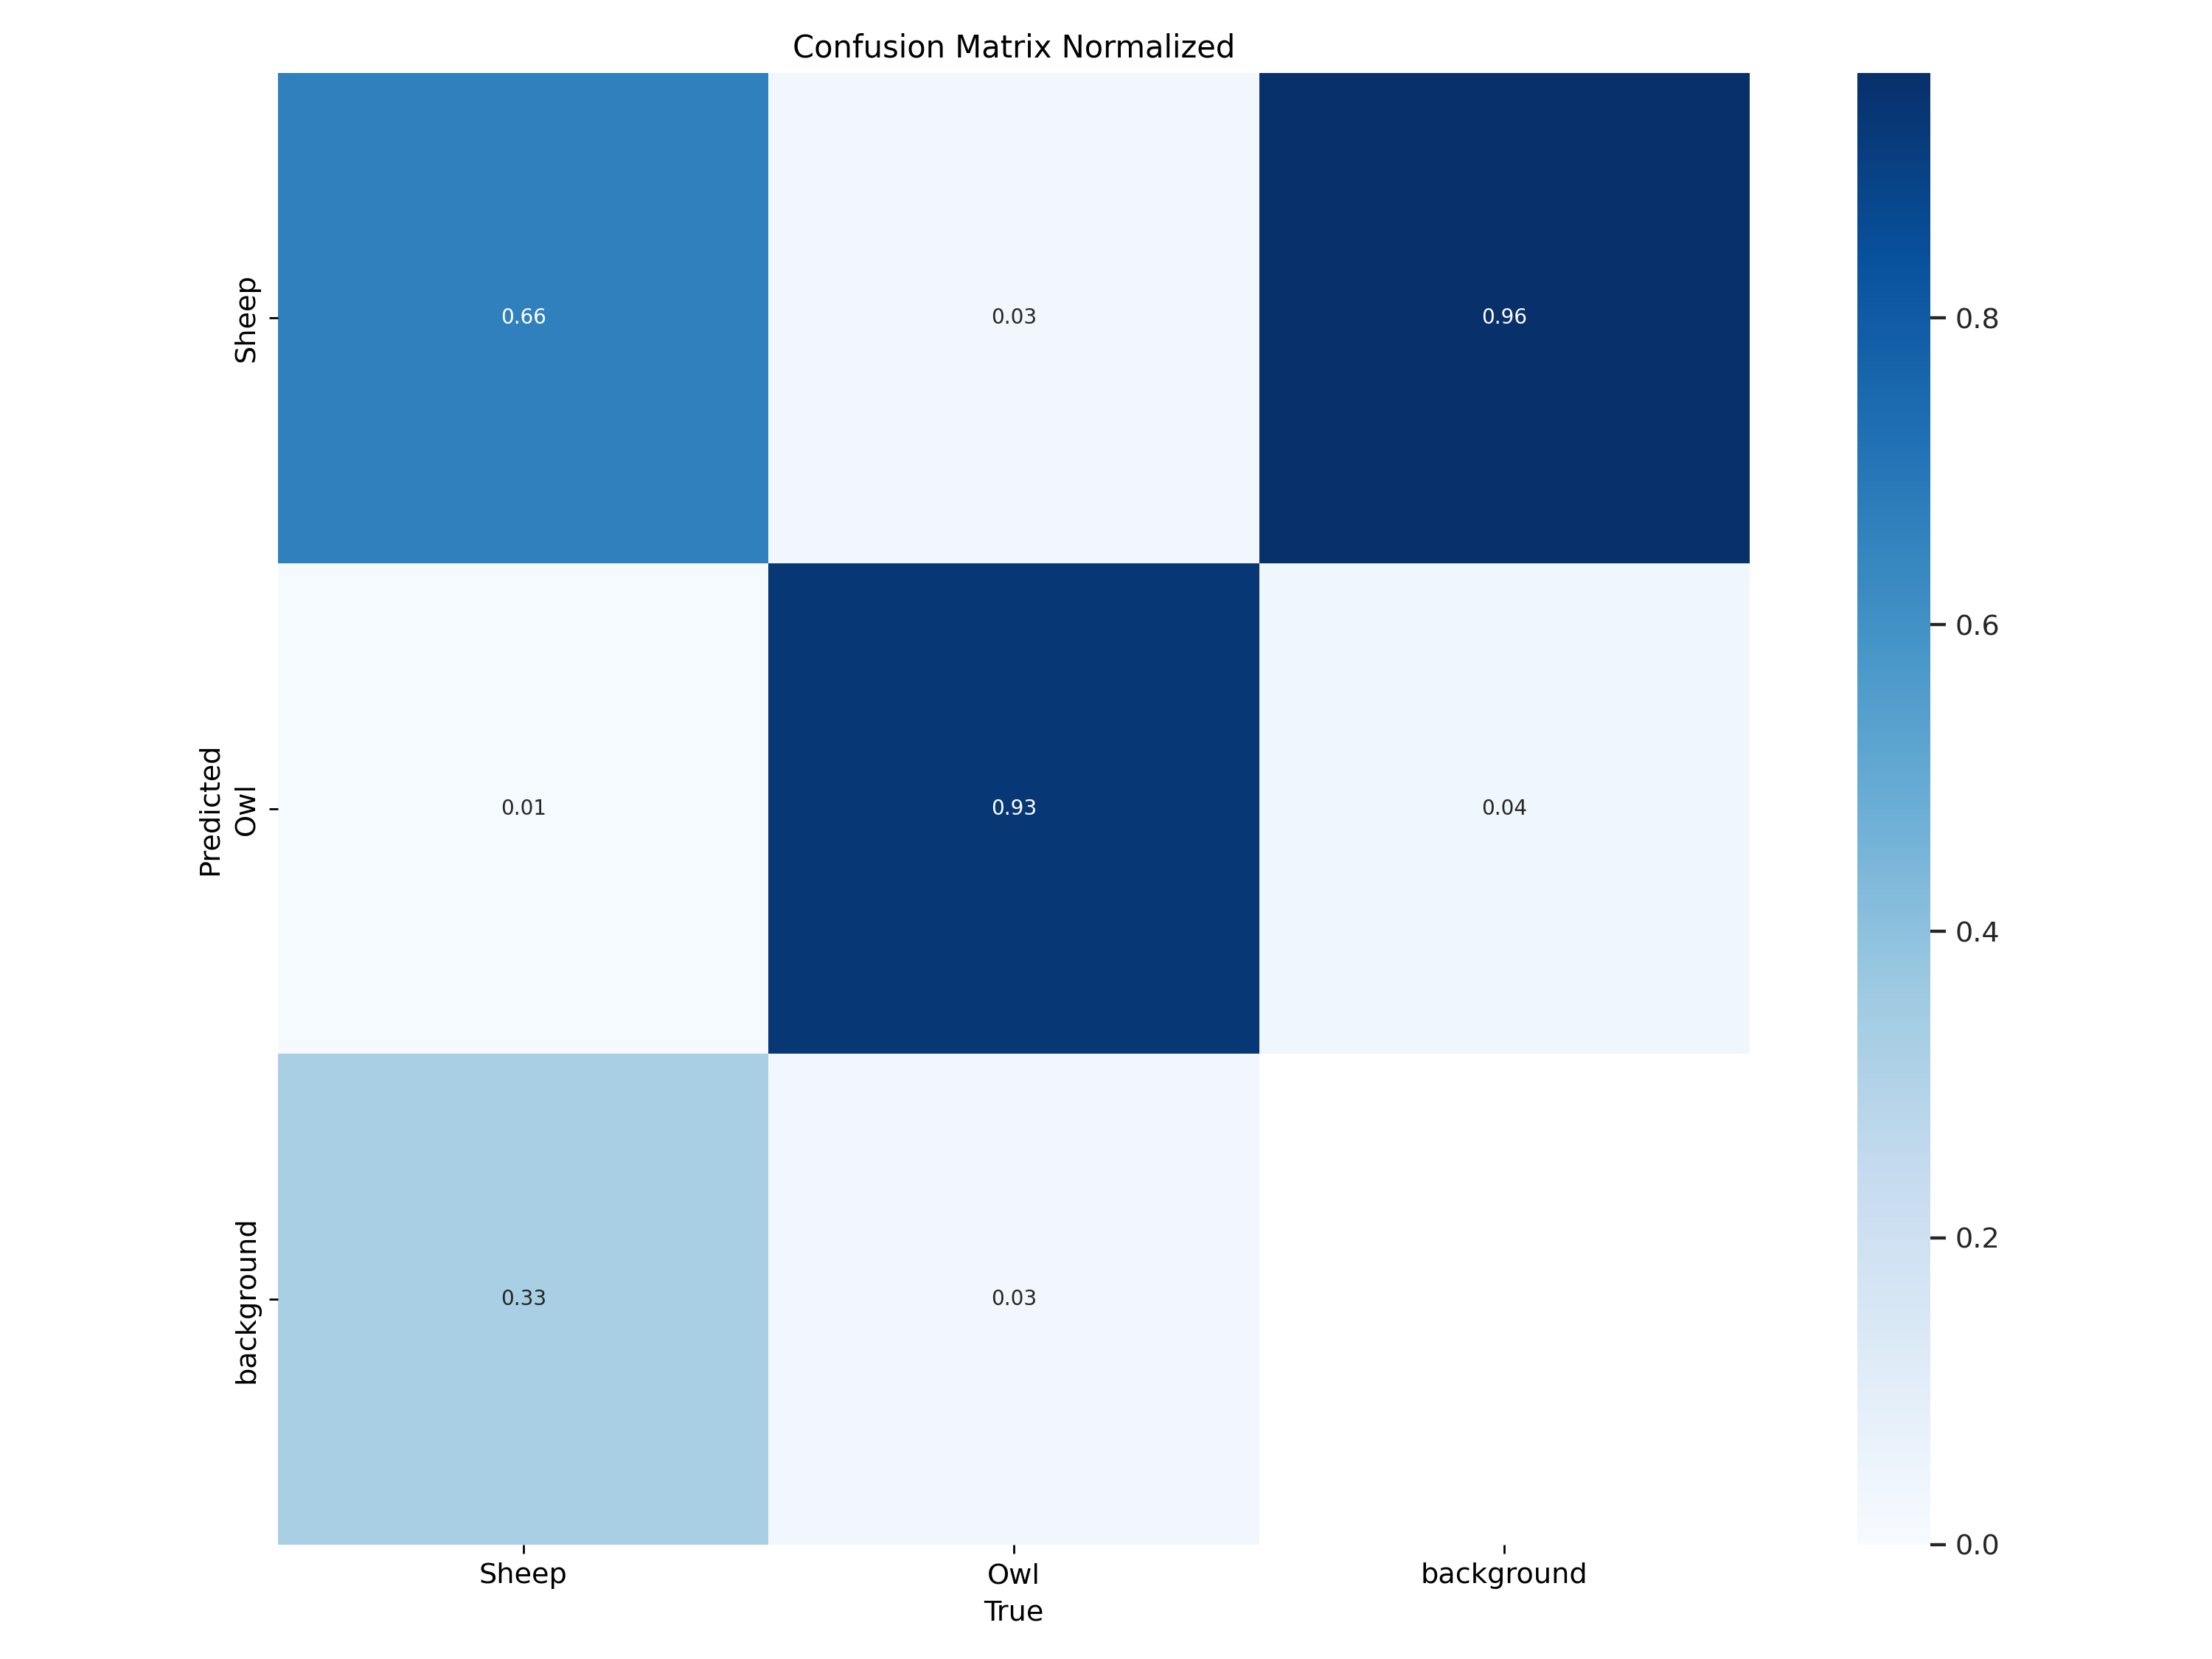

In [ ]:
display(Image.open('/content/runs/detect/train/confusion_matrix_normalized.png'))

In [ ]:
best_model = YOLO('/content/runs/detect/train/weights/best.pt')

In [ ]:
metrics = best_model.val(data="/content/drive/MyDrive/Colab Notebooks/Owl-Sheep/dataset.yaml", split="test")

Ultralytics YOLOv8.1.11 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs
WARNING ⚠️ renaming data YAML 'validation' key to 'val' to match YOLO format.


val: Scanning /content/drive/MyDrive/Colab Notebooks/Owl-Sheep/labels/test.cache... 267 images, 0 backgrounds, 0 corrupt: 100%|██████████| 267/267 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


                   all        267        489      0.765       0.67      0.716      0.532
                 Sheep        267        396      0.675      0.523       0.55      0.349
                   Owl        267         93      0.854      0.816      0.882      0.716
Speed: 0.3ms preprocess, 6.9ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val


On the **test set**, the **F1-Confidence Curve** (*runs\detect\val\F1_curve.png*) *tekst u kurzivu*indicates that while owl detection remains robust, the performance for sheep detection has a lower peak F1 score. The best overall performance for all classes occurs at a confidence threshold lower than that of the validation set, with an F1 score of 0.71.

The **confusion matrix** reveals that accuracy for owls (88%) and background (91%) remains high, but it's slightly lower for sheep (64%) compared to the validation set. Misclassifications of sheep as background occur 34% of the time, which suggests further areas for improvement in differentiating sheep within the test data. Generally, the model performance on the test set is a bit lower than on the validation set, signaling a need for continued optimization, especially in sheep detection.

Additional metrics are available in the directory runs\detect\val.

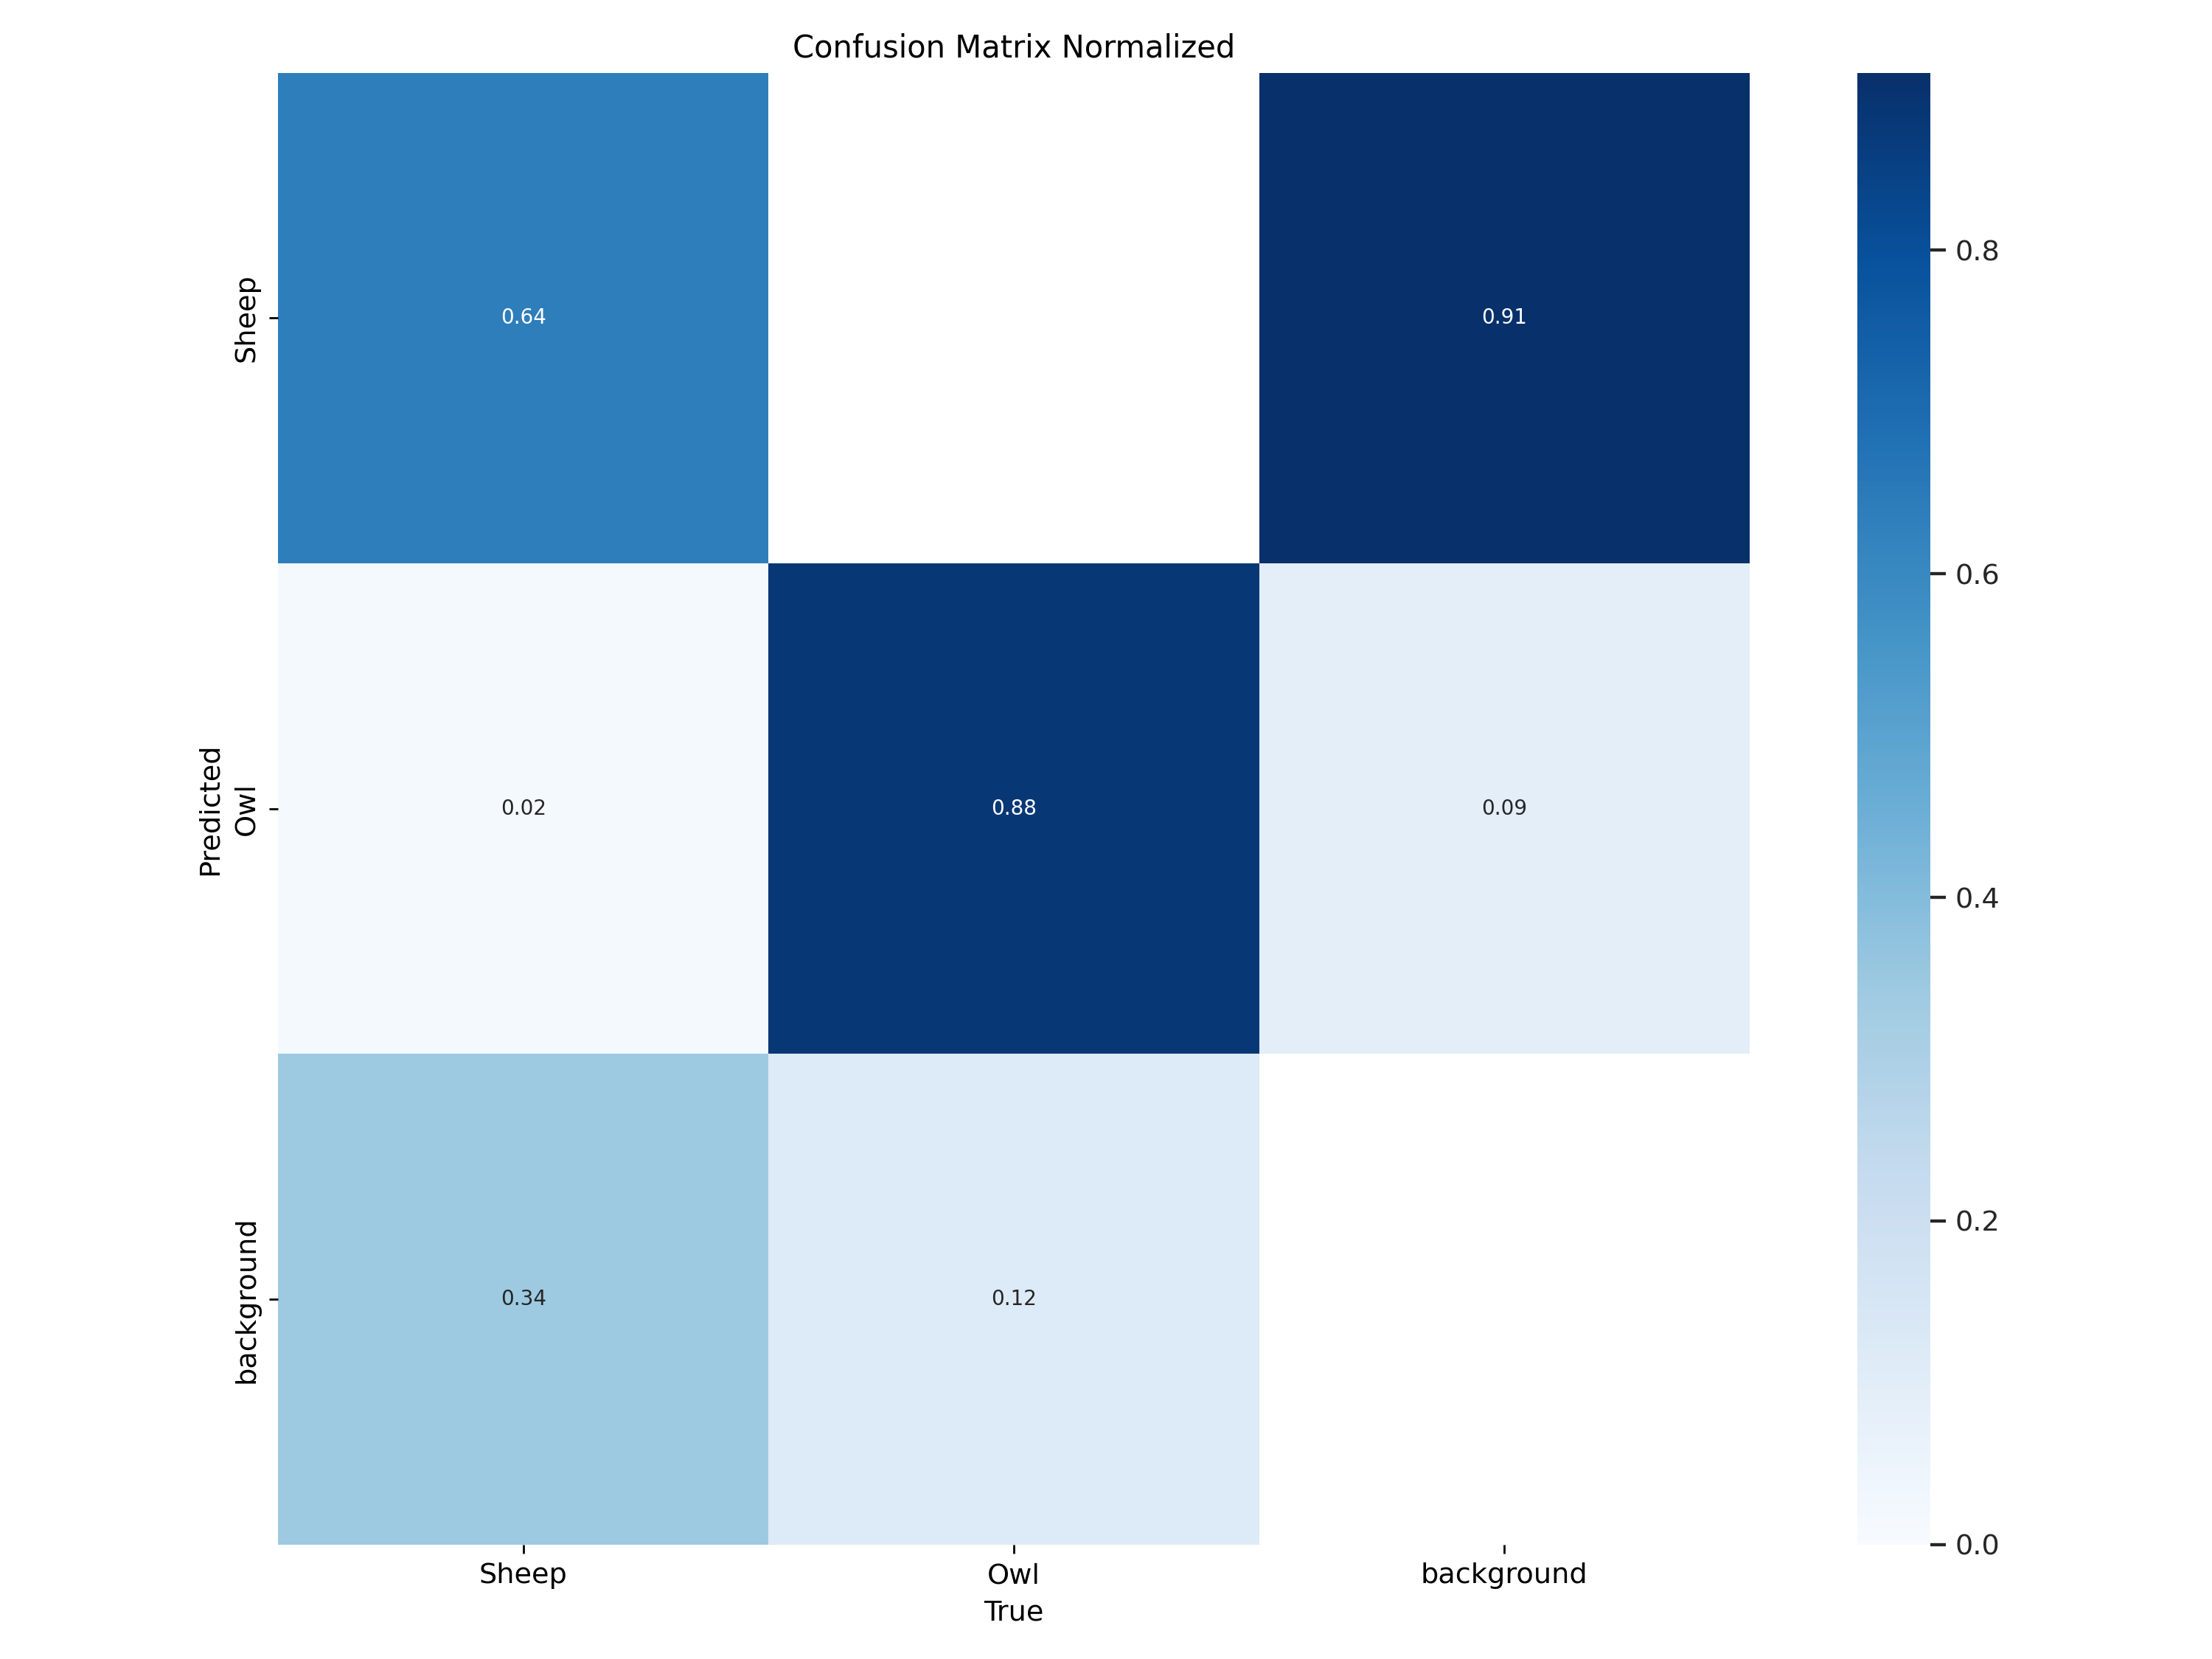

In [ ]:
display(Image.open('/content/runs/detect/val/confusion_matrix_normalized.png'))

# Making predictions


---
In *predict_from_folder.py*


In this section, we display the predicted labels and bounding boxes alongside the actual ones. While there may be an automated method for this comparison, I was unable to find one, so I devised my own approach.


Here, we first create visualizations that show the model's predicted labels and bounding boxes. Then, on these same images, we overlay the actual labels to compare the predicted and true data.



In [ ]:
# Directory containing your test images
test_images_directory = '/content/drive/MyDrive/Colab Notebooks/Owl-Sheep/images/test/'

# Iterate over all images in the test directory
for image_file in os.listdir(test_images_directory):
    # Check if file is an image
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Construct the full path to the image file
        image_path = os.path.join(test_images_directory, image_file)

        # Load the image
        im = Image.open(image_path)

        # Perform prediction
        results = best_model.predict(source=im, save=True)  # Assuming 'save=True' saves the image with plotted boxes

        # Display the saved image with bounding boxes
        saved_image_path = f'runs/detect/predict{image_file}'

In [ ]:
from PIL import ImageDraw, ImageFont
import cv2

# Assuming `model_best` is your loaded YOLO model
test_images_directory = '/content/runs/detect/predict'
true_labels_directory = '/content/drive/MyDrive/Colab Notebooks/Owl-Sheep/labels/test/'

# Define your class names based on the IDs in your label files
class_names = {0: "Sheep", 1: "Owl"}


def draw_true_labels(image, labels, color=(255, 0, 0)):  # True labels in blue
    h, w = image.shape[:2]
    for label in labels:
        class_id, x_center, y_center, width, height = [float(x) for x in label.split()]
        class_name = class_names.get(int(class_id), "Unknown")  # Get class name from dictionary

        # Convert from normalized to absolute coordinates
        left = int((x_center - width / 2) * w)
        top = int((y_center - height / 2) * h)
        right = int((x_center + width / 2) * w)
        bottom = int((y_center + height / 2) * h)

        # Draw rectangle and class name
        cv2.rectangle(image, (left, top), (right, bottom), color, 2)
        cv2.putText(image, class_name, (left, bottom + 25), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

for image_file in os.listdir(test_images_directory):
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(test_images_directory, image_file)
        label_path = os.path.join(true_labels_directory, image_file.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt'))

        # Load image
        image = cv2.imread(image_path)

        # Load true labels and draw them
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                true_labels = f.read().strip().split('\n')
            draw_true_labels(image, true_labels)


        # Save or display the image
        cv2.imwrite(f'runs/detect/predict/predicted_and_true/{image_file}', image)

Results are available in *runs\detect\predict\predicted_and_true*.

# Why model perform better on owls then on sheep?

The model's superior performance on owls compared to sheep may be partly attributed to inconsistencies in the labeling of the dataset. In instances where sheep are grouped together, they are sometimes labeled as a single entity, while in other cases, each sheep is labeled individually. This inconsistency could confuse the model. Although further optimization of the model is necessary, it's likely that these irregularities in the dataset contribute significantly to the confusion. Here are some examples (blue boxes) that illustrate this point.

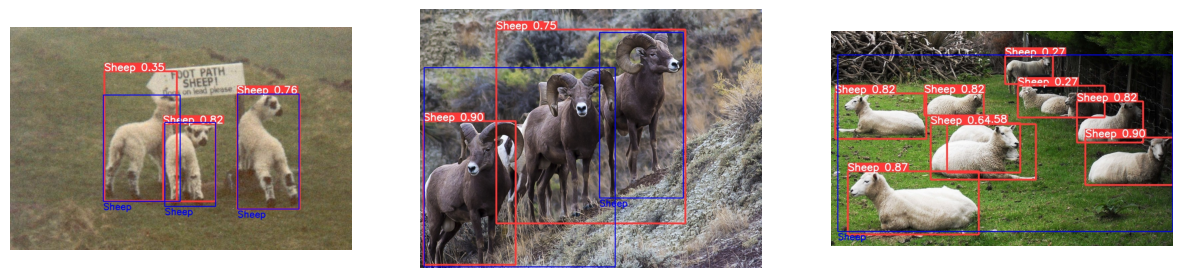